In [1]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 1/31/2023

import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math
import mpl_axes_aligner
# !{sys.executable} -m pip install mygene
import mygene
mg = mygene.MyGeneInfo()
from adjustText import adjust_text

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)
print('loaded')

# !{sys.executable} -m pip install goenrichment

loaded


### VIRF and IRF sequence comparison

In [16]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def combine_cmaps(cmaplist, numlist):
    cmaplist2 = []
    for c, n in zip(cmaplist, numlist):
        cmaplist2.append(c(np.linspace(0, 1, n)))
    
    cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmp', cmap)
    print(cmap)
    return cmap

#### MSA featured in Fig. 5A

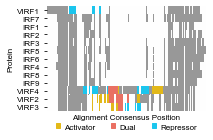

In [198]:
from Bio import AlignIO
# from Bio.Alphabet import IUPAC, Gapped
from Bio.Align import MultipleSeqAlignment as MSA
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

align = AlignIO.read('../Alignment Files/VIRF1-4_IRF1-9_alignment_file.aln', 'clustal')
uniprot_position = 1
name = 0
name_position = 2
domain = False

startA = {'VIRF1':[], 'VIRF2':[201, 361], 'VIRF3':[191], 'VIRF4':[381, 611]}
endA = {'VIRF1':[], 'VIRF2':[270, 380], 'VIRF3':[240], 'VIRF4':[390, 690]}
startR = {'VIRF1':[151], 'VIRF2':[], 'VIRF3':[271], 'VIRF4':[161, 301, 511]}
endR = {'VIRF1':[230], 'VIRF2':[], 'VIRF3':[320], 'VIRF4':[240, 310, 590]}
startD = {'VIRF1':[], 'VIRF2':[271], 'VIRF3':[241], 'VIRF4':[311]}
endD = {'VIRF1':[], 'VIRF2':[350], 'VIRF3':[270], 'VIRF4':[380]}

# uniprotIDs = []
proteins = []
sequences = []
newstartA = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}
newendA = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}
newstartR = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}
newendR = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}
newstartD = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}
newendD = {'VIRF1':[], 'VIRF2':[], 'VIRF3':[], 'VIRF4':[]}


for line in align:
    counter = 0
    prot = line.id.split('|')[2]
    proteins.append(prot)
    seq2convert = list(line.seq)
    converted = []
    for aa, pos in zip(seq2convert, list(range(1, len(seq2convert) + 1))):
        if aa == '-':
            counter += 1
            converted.append(0)
        else:
            converted.append(1)
            if prot in startA:
                currpos = pos - counter
                for currdict, newdict in zip([startA, endA, startR, endR, startD, endD], [newstartA, newendA, newstartR, newendR, newstartD, newendD]):
                    if len(currdict[prot]) != 0:
                        for val in currdict[prot]:
                            if val == currpos:
#                                 print('YES')
                                newdict[prot].append(pos)

    sequences.append(converted)

msa = pd.DataFrame({'Protein':proteins, 'Sequence':sequences})
msa2 = pd.DataFrame(msa['Sequence'].to_list())
msa2 = msa2.T.rename({c:str(int(c)+1) for c in msa2.columns}).T
msa2.index = msa['Protein']

for s, e, v in zip([newstartA, newstartR, newstartD], [newendA, newendR, newendD], [2, 3, 4]):
    for p in ['VIRF1', 'VIRF2', 'VIRF3', 'VIRF4']:
        for c in msa2.columns:
            for i, j in zip(s[p], e[p]):
                if (int(c) >= i) & (int(c) <= j):
                    if msa2.loc[p, c] != 0:
                        msa2.loc[p, c] = v

msa2

hexcolors = ['#FFFFFF', '#999999', '#E3B919', '#1BC6EE', '#EA7063']
rgbcolors = [rgb_to_dec(hex_to_rgb(c)) for c in hexcolors]

cmap = LinearSegmentedColormap.from_list('test', rgbcolors, N=5)

xrange = range(0, len(msa2.T), 200)
yticks = list(msa['Protein'])

plt.figure(figsize=(3,2))
sns.heatmap(msa2, cmap=cmap, cbar=False)
plt.xticks(ticks=[], labels=[], rotation=0)
plt.xlabel('Alignment Consensus Position', labelpad=2.5)
plt.yticks(ticks=[t + 0.5 for t in list(range(len(yticks)))], labels=yticks)

A_bar = mpatches.Patch(color=hexcolors[2], label='Activator')
B_bar = mpatches.Patch(color=hexcolors[3], label='Repressor')
R_bar = mpatches.Patch(color=hexcolors[4], label='Dual')
plt.legend(handles=[A_bar, R_bar, B_bar], loc='upper center', bbox_to_anchor=(0.5, -0.05),
           frameon=False, handlelength=0.5, handleheight=0.5, handletextpad=0.5, ncol=3)

plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 5/VIRF1-4_IRF1-9_MSA_domains.png', dpi=1200)


#### Dot plot with effect of perturbing motifs/critical residues featured in Fig. 5H

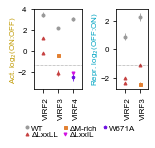

In [199]:
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo.csv', sep=',')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo.csv', sep=',')

def process_df(df, effect, tilefilter):
    if effect == 'Activation':
        df['Avg'] = -1*df['Avg']
        
    labels = list(df['label'])
    newlabels = []
    for l in labels:
        if 'WT' in l:
            newlabels.append(l)
        elif 'del5' in l:
            l_items = l.split('_')
            mut = l_items[-1][0] + str(int(l_items[-1][1:-4]) - 1) + 'del5'
            newlabels.append('_'.join(l_items[:-1] + [mut]))
        else:
            l_items = l.split('_')
            mut = l_items[-1][0] + str(int(l_items[-1][1:-1]) - 1) + l_items[-1][-1]
            newlabels.append('_'.join(l_items[:-1] + [mut]))

    df['label'] = newlabels
    
    df = df[df['label'].str.contains(tilefilter)]
    df = df[df['label'].str.contains('WT|L321del5|D336del5|M261del5|E271del5|W671A|G676del5')]
    df['Protein'] = df['label'].str.split('_').str[1]
    df['Mutant'] = df['label'].str.split('_').str[-1]
    df = df[['Protein', 'Mutant', 'Avg', 'Standard Error']]
    df = df.replace(['Q2HR71', 'F5HIC6', 'Q2HR73'], ['VIRF2', 'VIRF3', 'VIRF4'])
    df = df.sort_values(by=['Protein', 'Mutant'], ascending=[True, False])
    df = df.replace(['L321del5', 'D336del5', 'M261del5', 'E271del5', 'G676del5'], ['dLxxLL', 'dLxxLL', 'dMxxLM', 'dLxxLL', 'dLxxIL'])
    
    return df

Act = process_df(Act, 'Activation', 'Q2HR71_031|F5HIC6_027|Q2HR73_062')
Rep = process_df(Rep, 'Repression', 'Q2HR71_031|F5HIC6_025')

colorsTitle = ['#01a4c2', '#c29d09']
# colorDict = {'WT':'#999999', '\u0394LxxLL':'#D3674F', '\u0394MxxLLM':'#B23D99', 'W671A':'#C68D54'}
colorDict = {'WT':'#999999', 'dLxxLL':'#C64242', 'dMxxLM':'#E28133', 'W671A':'#6B0CE1', 'dLxxIL':'#D110E1'}

def plot_VIRFs(df, subplot, axlabel, labcolor, title):
    prot_xpos_dict = {}
    xpos_prot_dict = {}
    xpos = 0
    for p, m, y, e in zip(list(df['Protein']), list(df['Mutant']), list(df['Avg']), list(df['Standard Error'])):
        if p not in prot_xpos_dict:
            prot_xpos_dict[p] = xpos
            xpos_prot_dict[xpos] = p
            xpos += 1
            
        x = prot_xpos_dict[p]
        if m == 'WT':
            ax[subplot].plot(x, y, color=colorDict[m], marker='o', markersize=3, zorder=1)
        elif m == 'dLxxLL':
            ax[subplot].plot(x, y, color=colorDict[m], marker='^', markersize=3, zorder=1)
        elif m == 'dMxxLM':
            ax[subplot].plot(x, y, color=colorDict[m], marker='s', markersize=3, zorder=1)
        elif m == 'dLxxIL':
            ax[subplot].plot(x, y, color=colorDict[m], marker='v', markersize=3, zorder=1)
        elif m == 'W671A':
            ax[subplot].plot(x, y, color=colorDict[m], marker='p', markersize=3, zorder=1)
        ax[subplot].errorbar(x, y, yerr=e, color=colorDict[m], zorder=0, lw=0.8)

    if subplot == 0:
        ax[0].axhline(y=-1.393846406032031, ls=':', lw=0.5, color='#333333')
        ax[0].set_ylim(ax[0].get_ylim()[0]-0.5, ax[0].get_ylim()[1])
    else:
        ax[1].axhline(y=-1.071410423724703, ls=':', lw=0.5, color='#333333')
        
    ax[subplot].set_xlim(ax[subplot].get_xlim()[0]-0.5, ax[subplot].get_xlim()[1]+0.5)
    ax[subplot].set_xticks(ticks=list(xpos_prot_dict.keys()))
    ax[subplot].set_xticklabels(labels=list(prot_xpos_dict.keys()), rotation=90, ha='left')
    ax[subplot].legend('', frameon=False)
    ax[subplot].set_ylabel(axlabel, color=labcolor, labelpad=-1)
    ax[subplot].set_title(title, fontsize=8) 


fig, ax = plt.subplots(1, 2, figsize=(2.2, 1.8), gridspec_kw={'width_ratios':[3,2]})

plot_VIRFs(Act, 0, 'Act. log$_2$(ON:OFF)', colorsTitle[1], '')
plot_VIRFs(Rep, 1, 'Repr. log$_2$(OFF:ON)', colorsTitle[0], '')
plt.tight_layout()

legend_elements = [Line2D([0], [0], marker='o', color=colorDict['WT'], label='WT', mfc=colorDict['WT'], markersize=3),
                   Line2D([0], [0], marker='^', color=colorDict['dLxxLL'], label='\u0394LxxLL', mfc=colorDict['dLxxLL'], markersize=3),
                   Line2D([0], [0], marker='s', color=colorDict['dMxxLM'], label='\u0394M-rich', mfc=colorDict['dMxxLM'], markersize=3),
                   Line2D([0], [0], marker='v', color=colorDict['dLxxIL'], label='\u0394LxxIL', mfc=colorDict['dLxxIL'], markersize=3),
                   Line2D([0], [0], marker='p', color=colorDict['W671A'], label='W671A', mfc=colorDict['W671A'], markersize=3)]
#                    Line2D([0], [0], marker='o', color='#BBBBBB', label='Unique', mfc='white', markersize=7)]
plt.legend(handles=legend_elements, loc='upper center', frameon=False, bbox_to_anchor=(-1.1, -0.35),
           labelspacing=0, handlelength=0, handletextpad=0.5, ncol=3, columnspacing=1)
 
plt.savefig('../Individual Figure Panels/Figure 5/VIRF_domain_perturbation_summary.png', dpi=1200, bbox_inches='tight')

#### RNA-seq summary of WT vs mut VIRF2 (Fig. 5J) and VIRF4 (Fig. 5K), with IFN-stimulated genes (those that are significantly upregulated in an IFN treatment condition) highlighted in red

In [19]:
IFNonly = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-nodox_CL048_noIFN-dox_varIFN.csv')
effectlim = 1
IFNonly = IFNonly[((IFNonly['log2FoldChange']>=effectlim) | (IFNonly['log2FoldChange']<=-effectlim)) & (IFNonly['padj']<=0.05)]
ISGs = list(IFNonly['symbol'])
IFNonly


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,ENSG00000170006,45.716610,-2.693661,0.605092,-4.451655,8.521111e-06,1.168510e-04,TMEM154
1,ENSG00000198727,9471.246376,-2.454813,0.482506,-5.087634,3.625584e-07,7.012256e-06,CYTB
2,ENSG00000055163,34.146767,-2.236609,0.660954,-3.383908,7.146192e-04,5.334335e-03,CYFIP2
3,ENSG00000165092,203.227388,-2.077142,0.273641,-7.590769,3.180133e-14,1.809209e-12,ALDH1A1
4,ENSG00000260400,33.356955,-2.045025,0.660870,-3.094445,1.971812e-03,1.243087e-02,ENSG00000260400
...,...,...,...,...,...,...,...,...
13379,ENSG00000132530,152.053272,10.578754,4.001309,2.643823,8.197552e-03,3.975219e-02,XAF1
13380,ENSG00000135114,233.295932,11.198402,4.001155,2.798792,5.129414e-03,2.747182e-02,OASL
13381,ENSG00000089127,1550.183664,12.487385,1.444062,8.647405,5.268376e-18,4.006360e-16,OAS1
13382,ENSG00000157601,6606.843821,13.288612,1.780123,7.464995,8.330299e-14,4.569374e-12,MX1


<ipython-input-27-c610993a892e>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['WT', '\u0394L321\n-S325'], rotation=90)
<ipython-input-27-c610993a892e>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['WT', '\u0394L321\n-S325'], rotation=90)


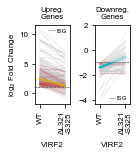

In [27]:
V2deseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290-CL048_dox.csv')
V2mdeseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL458-CL048_dox.csv')

V2deseq = V2deseq[['symbol', 'log2FoldChange', 'padj']].rename(columns={'log2FoldChange':'WT_L2FC', 'padj':'WT_padj'})
V2mdeseq = V2mdeseq[['symbol', 'log2FoldChange', 'padj']].rename(columns={'log2FoldChange':'mut_L2FC', 'padj':'mut_padj'})

x = 1
V2comb = pd.merge(V2deseq, V2mdeseq, on='symbol', how='inner')
V2comb = V2comb[((V2comb['WT_L2FC']>x) | (V2comb['WT_L2FC']<-x)) & (V2comb['WT_padj']<0.05)]# &
#                 ((V2comb['mut_L2FC']>1) & (V2comb['mut_padj']<0.05) | (V2comb['mut_L2FC']<-1) & (V2comb['mut_padj']<0.05))]

V2comb['Direction'] = np.where((V2comb['WT_L2FC']>1), 'UP', 'DOWN')
V2comb_wt = V2comb[['symbol', 'WT_L2FC', 'Direction']].rename(columns={'WT_L2FC':'L2FC'})
V2comb_wt['VIRF2 Type'] = 'WT'
V2comb_mut = V2comb[['symbol', 'mut_L2FC', 'Direction']].rename(columns={'mut_L2FC':'L2FC'})
V2comb_mut['VIRF2 Type'] = 'mut'
V2comb = pd.concat([V2comb_wt, V2comb_mut])
V2comb['ISG'] = np.where(V2comb['symbol'].isin(ISGs), 1, 0)
# V2comb
fig, ax = plt.subplots(1, 2, figsize=(1.95,2.2))
# fig, ax = plt.subplots(1, 2, figsize=(1.7,2.2))
pal = sns.color_palette(['#BBBBBB', '#C64242'])
sns.lineplot(data=V2comb[V2comb['Direction']=='UP'], x='VIRF2 Type', y='L2FC', estimator=None, units='symbol', ax=ax[0], hue='ISG', palette=pal, alpha=0.5, lw=0.5)
# sns.lineplot(data=V2comb[V2comb['Direction']=='UP'], x='VIRF2 Type', y='L2FC', estimator=None, units='symbol', ax=ax[0], color='#BBBBBB', alpha=0.5, lw=0.5)
sns.lineplot(data=V2comb[V2comb['Direction']=='UP'], x='VIRF2 Type', y='L2FC', ax=ax[0], err_style='bars', ci=0, color='#DAA520', lw=2)
legend_elements = [Line2D([0], [0], color='#C64242', label='ISG', lw=0.5)]
ax[0].legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor=(1, 1), labelspacing=0, handletextpad=0.25, handlelength=1, borderpad=0.1, fontsize=6)
ax[0].set_xlim(-0.2,1.2)
ax[0].set_xticklabels(['WT', '\u0394L321\n-S325'], rotation=90)
ax[0].set_xlabel('VIRF2', labelpad=7)
ax[0].set_ylabel('log$_2$ Fold Change', labelpad=1) # (Upregulated Genes)')
ax[0].set_title('Upreg.\nGenes', fontsize=8)
ax[0].axhspan(ymin=ax[0].get_ylim()[0], ymax=1, xmin=(ax[0].get_xlim()[0] + 0.3), xmax=(ax[0].get_xlim()[1] - 0.3), color='white', alpha=0.5, zorder=10)
ax[0].axhline(y=1, lw=0.5, ls='--', color='k', zorder=100)

sns.lineplot(data=V2comb[V2comb['Direction']=='DOWN'], x='VIRF2 Type', y='L2FC', estimator=None, units='symbol', ax=ax[1], hue='ISG', palette=pal, alpha=0.5, lw=0.5)
# sns.lineplot(data=V2comb[V2comb['Direction']=='DOWN'], x='VIRF2 Type', y='L2FC', estimator=None, units='symbol', ax=ax[1], color='#BBBBBB', alpha=0.5, lw=0.5)
sns.lineplot(data=V2comb[V2comb['Direction']=='DOWN'], x='VIRF2 Type', y='L2FC', ax=ax[1], err_style='bars', ci=0, color='#00b0c7', lw=2)
legend_elements = [Line2D([0], [0], color='#C64242', label='ISG', lw=0.5)]
ax[1].legend(handles=legend_elements, loc='lower right', frameon=False, bbox_to_anchor=(1, 0), labelspacing=0, handletextpad=0.25, handlelength=1, borderpad=0.1, fontsize=6)
ax[1].set_xlim(-0.2,1.2)
ax[1].set_xticklabels(['WT', '\u0394L321\n-S325'], rotation=90)
ax[1].set_xlabel('VIRF2', labelpad=7)
# ax[1].set_ylabel('log$_2$ Fold Change') # (Downregulated Genes)')
ax[1].set_ylabel('')
ax[1].set_title('Downreg.\nGenes', fontsize=8)
ax[1].axhspan(ymin=-1, ymax=ax[1].get_ylim()[1], xmin=(ax[1].get_xlim()[0] + 0.3), xmax=(ax[1].get_xlim()[1] - 0.3), color='white', alpha=0.5, zorder=10)
ax[1].axhline(y=-1, lw=0.5, ls='--', color='k', zorder=100)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 5/VIRF2_WT-vs-mut_l2fc_shared_genes.png', dpi=1200)

<ipython-input-28-a88e580dbd82>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['WT', 'W671A'], rotation=90)


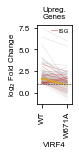

In [28]:
V4deseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL195-CL048_dox.csv')
V4mdeseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL459-CL048_dox.csv')

V4deseq = V4deseq[['symbol', 'log2FoldChange', 'padj']].rename(columns={'log2FoldChange':'WT_L2FC', 'padj':'WT_padj'})
V4mdeseq = V4mdeseq[['symbol', 'log2FoldChange', 'padj']].rename(columns={'log2FoldChange':'mut_L2FC', 'padj':'mut_padj'})

x = 1
V4comb = pd.merge(V4deseq, V4mdeseq, on='symbol', how='inner')
V4comb = V4comb[(((V4comb['WT_L2FC']>x) | (V4comb['WT_L2FC']<-x)) & (V4comb['WT_padj']<0.05))]# &
#                 ((V4comb['mut_L2FC']>1) & (V4comb['mut_padj']<0.05) | (V4comb['mut_L2FC']<-1) & (V4comb['mut_padj']<0.05))]

V4comb['Direction'] = np.where((V4comb['WT_L2FC']>1), 'UP', 'DOWN')
V4comb_wt = V4comb[['symbol', 'WT_L2FC', 'Direction']].rename(columns={'WT_L2FC':'L2FC'})
V4comb_wt['VIRF4 Type'] = 'WT'
V4comb_mut = V4comb[['symbol', 'mut_L2FC', 'Direction']].rename(columns={'mut_L2FC':'L2FC'})
V4comb_mut['VIRF4 Type'] = 'mut'
V4comb = pd.concat([V4comb_wt, V4comb_mut])
V4comb['ISG'] = np.where(V4comb['symbol'].isin(ISGs), 1, 0)
# V4comb
fig, ax = plt.subplots(figsize=(1.05,2.2))
pal = sns.color_palette(['#BBBBBB', '#C64242'])
sns.lineplot(data=V4comb[V4comb['Direction']=='UP'], x='VIRF4 Type', y='L2FC', estimator=None, units='symbol', ax=ax, hue='ISG', palette=pal, alpha=0.5, lw=0.5)
# sns.lineplot(data=V4comb[V4comb['Direction']=='UP'], x='VIRF4 Type', y='L2FC', estimator=None, units='symbol', ax=ax, color='#BBBBBB', alpha=0.5, lw=0.5)
sns.lineplot(data=V4comb[V4comb['Direction']=='UP'], x='VIRF4 Type', y='L2FC', ax=ax, err_style='bars', ci=0, color='#DAA520', lw=2)
legend_elements = [Line2D([0], [0], color='#C64242', label='ISG', lw=0.5)]
ax.legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor=(1, 1), labelspacing=0, handletextpad=0.25, handlelength=1, borderpad=0.1, fontsize=6)
ax.set_xlim(-0.2,1.2)
ax.set_xticklabels(['WT', 'W671A'], rotation=90)
ax.set_xlabel('VIRF4')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_ylabel('log$_2$ Fold Change', labelpad=1) # (Upregulated Genes)')
ax.set_title('Upreg.\nGenes', fontsize=8)
ax.axhspan(ymin=ax.get_ylim()[0]+0.2, ymax=1, xmin=(ax.get_xlim()[0] + 0.3), xmax=(ax.get_xlim()[1] - 0.3), color='white', alpha=0.5, zorder=10)
ax.axhline(y=1, lw=0.5, ls='--', color='k', zorder=100)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 5/VIRF4_WT-vs-mut_l2fc-UP-only_shared_genes.png', dpi=1200)

### Clustermaps as alternative visualization of VIRF2 and VIRF4 data

#### The following are not featured in a figure panel

In [30]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

# The following three scripts are from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        color map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def combine_cmaps(cmaplist, numlist):
    cmaplist2 = []
    for c, n in zip(cmaplist, numlist):
        cmaplist2.append(c(np.linspace(0, 1, n)))
    
    cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmp', cmap)
    print(cmap)
    return cmap


11.2213265172965 -4.211190881443129 170 33 53


<ipython-input-30-ea276821bc75>:53: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
<ipython-input-31-ef7a8bf1bdb4>:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


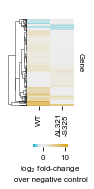

In [31]:
def combine_df(dflist, namelist):
    DF = pd.DataFrame()
    for df, name in zip(dflist, namelist):
        df = df[['symbol', 'log2FoldChange']].rename(columns={'symbol':'Gene', 'log2FoldChange':name})
        df = df[~df['Gene'].isin(filterout)]
        if len(DF) == 0:
            DF = df.copy()
        else:
            DF = pd.merge(DF, df, on='Gene', how='outer')
    return DF

virf2_wt = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290-CL048_dox.csv')
virf2_mut = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL458-CL048_dox.csv')

filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A', 'VIRF2_mut', 'VIRF4_mut']

x = 1.5
virf2 = combine_df([virf2_wt, virf2_mut], ['VIRF2 WT', 'VIRF2 mut'])
virf2 = virf2[((virf2['VIRF2 WT']>x) | (virf2['VIRF2 WT']<-x)) | ((virf2['VIRF2 mut']>x) | (virf2['VIRF2 mut']<-x))]
virf2 = virf2.set_index('Gene')
virf2 = virf2.fillna(0)
virf2 = virf2.dropna()

virf2 = virf2[['VIRF2 WT', 'VIRF2 mut']]
maxl2fc = max([max(list(virf2[c])) for c in virf2])
minl2fc = min([min(list(virf2[c])) for c in virf2])

num_up = int(round(256*(maxl2fc - 1)/(maxl2fc - minl2fc), 0)) # upregulated genes
num_mid = int(round(256*(2)/(maxl2fc - minl2fc), 0)) # middle
num_down = int(round(256*(-1 - minl2fc)/(maxl2fc - minl2fc), 0)) # downregulated genes

print(maxl2fc, minl2fc, num_up, num_mid, num_down)

cmap1 = get_continuous_cmap(['#00B0C7', '#EEEEEE'])
cmap2 = get_continuous_cmap(['#EEEEEE', '#EEEEEE'])
cmap3 = get_continuous_cmap(['#EEEEEE', '#DAA520'])
cmap = combine_cmaps([cmap1, cmap2, cmap3], [num_down, num_mid, num_up]) # build stack from bottom to top

g = sns.clustermap(virf2, mask=virf2.isnull(), cmap=cmap, figsize=(2.4, 1.8), cbar_pos=(0.2,-0.15,0.2,0.02),
                   dendrogram_ratio=(0.3,0.1), col_cluster=False,
                   cbar_kws={'orientation': 'horizontal', 'label':'log$_2$ fold-change\nover negative control'})
ax = g.ax_heatmap
ax.set_yticks([])
ax.set_ylabel(ylabel='Gene', rotation=-90, labelpad=10)
ax.set_xticks(ticks=ax.get_xticks())
ax.set_xticklabels(labels=['WT', '\u0394L321\n-S325'], rotation=90)
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
plt.tight_layout()
g.savefig('../Individual Figure Panels/Figure S6/VIRF2_WT-mut_RNA-seq_clustermap.png', dpi=1200)


<ipython-input-203-ea276821bc75>:53: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cmap = np.vstack((c for c in cmaplist2)) # build stack from bottom to top
<ipython-input-205-e9ddf694dca7>:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


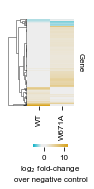

In [205]:
virf4_wt = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL195-CL048_dox.csv')
virf4_mut = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL459-CL048_dox.csv')

filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A', 'VIRF2_mut', 'VIRF4_mut']

x = 2
virf4= combine_df([virf4_wt, virf4_mut], ['VIRF4 WT', 'VIRF4 mut'])
virf4= virf4[((virf4['VIRF4 WT']>x) | (virf4['VIRF4 WT']<-x)) | ((virf4['VIRF4 mut']>x) | (virf4['VIRF4 mut']<-x))]
virf4= virf4.set_index('Gene')
virf4= virf4.fillna(0)
virf4= virf4.dropna()

virf4= virf4[['VIRF4 WT', 'VIRF4 mut']]
maxl2fc = max([max(list(virf4[c])) for c in virf4])
minl2fc = min([min(list(virf4[c])) for c in virf4])

num_up = int(round(256*(maxl2fc - 1)/(maxl2fc - minl2fc), 0)) # upregulated genes
num_mid = int(round(256*(2)/(maxl2fc - minl2fc), 0)) # middle
num_down = int(round(256*(-1 - minl2fc)/(maxl2fc - minl2fc), 0)) # downregulated genes

cmap1 = get_continuous_cmap(['#00B0C7', '#EEEEEE'])
cmap2 = get_continuous_cmap(['#EEEEEE', '#EEEEEE'])
cmap3 = get_continuous_cmap(['#EEEEEE', '#DAA520'])
cmap = combine_cmaps([cmap1, cmap2, cmap3], [num_down, num_mid, num_up]) # build stack from bottom to top

g = sns.clustermap(virf4, mask=virf4.isnull(), cmap=cmap, figsize=(2.4, 1.8), cbar_pos=(0.2,-0.15,0.2,0.02),
                   dendrogram_ratio=(0.3,0.1), col_cluster=False,
                   cbar_kws={'orientation': 'horizontal', 'label':'log$_2$ fold-change\nover negative control'})
ax = g.ax_heatmap
ax.set_yticks([])
ax.set_ylabel(ylabel='Gene', rotation=-90, labelpad=10)
ax.set_xticks(ticks=ax.get_xticks())
ax.set_xticklabels(labels=['WT', 'W671A'], rotation=90)

plt.tight_layout()
g.savefig('../Individual Figure Panels/Figure S6/VIRF4_WT-mut_RNA-seq_clustermap.png', dpi=1200)


### Modified Tiling Plots for VIRFs

#### Define functions and prepare files

In [2]:
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

WT_A = 0.21506548936633008
WT_R = 0.17315610959701574
orig_cutoffA = 1.0846347878236864
orig_cutoffR = 0.6987727639587653

# filter out library members with too few reads, add meta data about perturbation type, and calculate hits threshold
# screen_type should be 'Act' or 'Rep'
def process_screen(df, screen_type, sigma, counts_filter):
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    df = df[(df['countsSUM_R1']>=counts_filter) & (df['countsSUM_R2']>=counts_filter)]
    
    df = df.rename(columns={'label':'Oligo ID'})
    df['Type'] = np.where(df['Oligo ID'].str.contains('random'), 'random', 'substitution')
    df['Type'] = np.where(df['Oligo ID'].str.contains('del5'), 'deletion', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('fiducial'), 'fiducial', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('_WT'), 'WT', df['Type'])
    
    if screen_type == 'Act':
        df['R1'] = -df['R1']
        df['R2'] = -df['R2']
        df['Avg'] = -df['Avg']
        
    rand = list(df[df['Type']=='random']['Avg'])
    thresh = np.mean(rand) + sigma*np.std(rand)
    df['Hit'] = np.where(df['Avg']>=thresh, 1, 0)
    
    return df, thresh

# add additional information, including fiducial details, WT tile effect, and other meta data
# IMPORTANT: all mutations are off by +1, so this code corrects for that
def add_info(df, fiducials, maxTiles, prot_seqs):
    # merge in fiducial information and protein sequences
    df['Full Tile ID'] = df['Oligo ID'].str.split('_').str[1:].str.join('_')
    df = pd.merge(df, fiducials[['Full Tile ID', 'Gene', 'Effect']], on='Full Tile ID', how='left')
    df = pd.merge(df, prot_seqs, on='Full Tile ID', how='left')
    df['Effect'] = np.where(df['Effect'].isnull(), '-', df['Effect'])
    df['Tile ID'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[:-1].str.join('_'), '-')
    df['Mutation'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[-1], '-')
    
    # isolate mutations and position information
    df['Original'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Mutation'].str[0], '-')
    df['Position'] = np.where(df['Type']=='substitution', df['Mutation'].str[1:-1], '-')
    df['Perturbation'] = np.where(df['Type']=='substitution', df['Mutation'].str[-1], '-')
    df['Position'] = np.where(df['Type']=='deletion', df['Mutation'].str[1:-4], df['Position'])
    df['Perturbation'] = np.where(df['Type']=='deletion', 'del5', df['Perturbation'])
    df['Position'] = [int(p) - 1 if p!='-' else '-' for p in list(df['Position'])]
    
    # correct mutation position in the 'Mutation', 'Full Tile ID', and 'Oligo ID' fields
    df['Mutation'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Original'] + df['Position'].astype(str) + df['Perturbation'], df['Mutation'])
    df['Full Tile ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Tile ID'] + '_' + df['Mutation'], df['Full Tile ID'])
    df['Oligo ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), 'HHV-DMS_' + df['Full Tile ID'], df['Oligo ID'])
    
    df = pd.merge(df, maxTiles, on='Tile ID', how='outer')
    df['Effect'] = np.where(df['Effect_y'].isnull(), df['Effect_x'], df['Effect_y'])
    
    # fill in information for F5HCV3_060
    df['Tile Start'] = np.where(df['Tile ID']=='F5HCV3_060', 591, df['Tile Start'])
    df['Tile End'] = np.where(df['Tile ID']=='F5HCV3_060', 670, df['Tile End'])
    df['Protein'] = np.where(df['Tile ID']=='F5HCV3_060', 'RTA', df['Protein'])
    df['Virus Abbreviation'] = np.where(df['Tile ID']=='F5HCV3_060', 'KSHV', df['Virus Abbreviation'])
    df['Effect'] = np.where(df['Tile ID']=='F5HCV3_060', 'activator', df['Effect'])
    df = df.drop(columns=['Effect_x', 'Effect_y', 'Gene'])
    
    return df

# read in necessary files as dataframes: screen scores, fiducials, and details on original WT max tiles
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo.csv', sep=',')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo.csv', sep=',')

fiducials = pd.read_csv('../Supplemental Tables - CSV/fiducial_controls.csv', sep=',').drop(columns='Unnamed: 0')
fiducials['Number'] = fiducials.index + 1
fiducials['Full Tile ID'] = 'fiducial_' + fiducials['Number'].astype(str).str.zfill(3)
fiducials['Effect'] = np.where(fiducials['Description'].str.contains('Repr'), 'repressor', 'activator')
fiducials['Effect'] = np.where(fiducials['label'].str.contains('random'), '-', fiducials['Effect'])

maxTiles = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA), 'activator', '-')
maxTiles['Effect'] = np.where((maxTiles['Repression']>=orig_cutoffR), 'repressor', maxTiles['Effect'])
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA) & (maxTiles['Repression']>=orig_cutoffR), 'dual', maxTiles['Effect'])
maxTiles = maxTiles[['Tile ID', 'Tile Start', 'Tile End', 'Effect', 'Protein', 'Virus Abbreviation']]

prot_seqs = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV_Hits_DMS_codon-opt-proteins_oligos.csv')
prot_seqs = prot_seqs[['Name', 'Protein Sequence']].rename(columns={'Name':'Full Tile ID'})

# process files
Act, threshA = process_screen(Act, 'Act', 2, 50)
Act = add_info(Act, fiducials, maxTiles, prot_seqs)
# Act.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv', index=False)

Rep, threshR = process_screen(Rep, 'Rep', 2, 50)
Rep = add_info(Rep, fiducials, maxTiles, prot_seqs)
# Rep.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv', index=False)

print('Activation threshold: %s' % str(threshA))
print('Repression threshold: %s' % str(threshR))
print('Complete')

Activation threshold: -1.393846406032031
Repression threshold: -1.071410423724703
Complete


#### Perturbation tiling plots featured in Fig. S6D-J

In [6]:
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

font = {'family' : 'Arial',
        'size'   : 6}

matplotlib.rc('font', **font)

jpred4 = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/jpred4_results_summarized.csv').drop(columns='Protein Sequence')
dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
coords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}

# generate tiling plots containing all info and sequence
def tiling_plot(df, tile, label, effect_type, thresh, structure):
    savedir = '../Individual Figure Panels/Figure S6'
    # set variables based on effect type
    if effect_type == 'activator':
        color = '#D7AC00'
        ylabel = 'log$_2$(ON:OFF)\nActivation Score'
        sigma2 = 2*WT_A
        
    elif effect_type == 'repressor':
        color = '#23BEDB'
        ylabel = 'log$_2$(OFF:ON)\nRepression Score'
        sigma2 = 2*WT_R
    
    # check if output directory exists - if not, make directory
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    df = pd.merge(df, structure, on='Tile ID', how='left')
    df = df[df['Effect'].isin([effect_type, 'dual'])]
    tileList = [tile]
    ymax=4.5
    ymin=-3
    
    # for each tile, create plot with effect of all perturbations
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            print('No WT measurement for %s %s (%s)' % (virus, protein, tile))
            WT_seq = dropoutDict[tile]
            WT_struct = ''.join(['-']*80)
            print(WT_struct)
            start = coords[tile][0]
            end = coords[tile][1] + 1
            
        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            WT_struct = list(tempdf[tempdf['Type']=='WT']['Structure'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1
        xticks = list(range(start, end, 1))
        xticks_mod = [x - 0.5 for x in xticks]
        xrange = list(range(start, end+1, 5))
        
        # create dataframes for specific subplots
        struct_dict = {'-':'#FFFFFF', 'E':'#555555', 'H':'#AAAAAA'}
        WT_struct = [struct_dict[s] for s in WT_struct if s in struct_dict]
        struct_df = pd.DataFrame(index=xticks, data={'JPred4':list(WT_struct)}).T
        
        deletion = tempdf[tempdf['Type']=='deletion']
        deletion = deletion.sort_values(by='Position')
        delx = [p + 2 for p in list(deletion['Position'])]
        dely = list(deletion['Avg'])
        delyerr = list(deletion['Standard Error'])
        
        subs = tempdf[tempdf['Type']=='substitution']
        subs = subs.sort_values(by='Position')
        subx = list(subs['Position'])
        suby = list(subs['Avg'])
        subyerr = list(subs['Standard Error'])
        subaa = list(subs['Perturbation'])
        sub_nonhit = list(subs[subs['Hit']==0]['Position'])
        
        # initialize plots
        fig, ax = plt.subplots(3, 1, figsize=(4,1.3), gridspec_kw={'height_ratios':[1, 2, 17]}, sharex=False)
        plt.subplots_adjust(hspace=0.05)
        
        ax[0].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[0].set_xticks([])
        ax[0].set_ylim(1,2)
        ax[0].set_yticks([])
        ax[0].set_ylabel('', rotation=0, va='center', ha='right')
        ax[0].set_title('%s (%s)' % (label, tile), fontsize=8)
        sns.despine(left=True, bottom=True, ax=ax[0])
        for s, x in zip(list(WT_struct), xticks_mod):
            ax[0].add_patch(Rectangle((x, 1), 1, 1, edgecolor=s, facecolor=s))
            
        custom_patch = [Line2D([0], [0], color='#AAAAAA', marker='s', lw=0),
                       Line2D([0], [0], color='#555555', marker='s', lw=0)]
        ax[0].legend(custom_patch, ['Helix', 'Beta      '], loc='upper right',
                     bbox_to_anchor=(0, 2), frameon=False, handletextpad=-0.2,
                     labelspacing=0.1, borderpad=0, title='JPred4', title_fontsize=6, markerscale=0.5)
             
        # plot sequence on top with critical substitutions highlighted
        ax[1].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[1].xaxis.set_major_locator(MultipleLocator(5))
        ax[1].xaxis.set_minor_locator(MultipleLocator(1))
        ax[1].xaxis.set_ticklabels('')
        ax[1].set_ylim(0,2)
        ax[1].set_yticks([])
        sns.despine(left=True, bottom=True, ax=ax[1])
        
        for x, aa in zip(xticks, WT_seq):
            if x in sub_nonhit:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=4, color='#EA7063')
            else:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=4)
                
        # plot deletion scan data, with WT scores as horizontal span
        ax[2].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[2].xaxis.set_major_locator(MultipleLocator(5))
        ax[2].xaxis.set_minor_locator(MultipleLocator(1))
        ax[2].set_ylim(ymin, ymax)
        ax[2].axhline(y=thresh, color='#333333', ls=':', zorder=-5, lw=1)
        if 'WT' in list(tempdf['Type']):
            ax[2].axhspan(ymax=WT_vals[0], ymin=WT_vals[1], color=color, alpha=0.25, zorder=-2)
            ax[2].axhline(y=WT_avg, color=color, ls=':', zorder=-1, lw=1)
        
        for x in xrange:
            ax[2].axvline(x=x-0.5, color='#DDDDDD', ls=':', lw=1)
        
        plotdf_del = pd.DataFrame({'X':delx, 'Y':dely})
        sns.scatterplot(data=plotdf_del, x='X', y='Y', color=color, ax=ax[2], linewidth=0, size=0.2, legend=False)
        for x, y, ye in zip(delx, dely, delyerr):
            ax[2].errorbar(x, y, xerr=2.5, yerr=ye, color=color, zorder=100, linewidth=0.75)
        
        # plot substitution data
        for x, y, aa in zip(subx, suby, subaa):
            ax[2].annotate(text=aa, xy=(x, y), va='center', ha='center', size=4, color=color)
        
        ax[2].set_xlabel('Position along Protein')
#         ax[2].set_xlabel('Residue Position along %s (%s)' % (label, tile))
        ax[2].set_ylabel(ylabel)
        
        savename = '_'.join([virus, protein, tile, effect_type, 'perturb.png'])
#         plt.title(title)
        plt.savefig(os.path.join(savedir, savename), dpi=1200, bbox_inches='tight', transparent=True)
        plt.close()

tiling_plot(Act, 'Q2HR71_031', 'KSHV VIRF2', 'activator', threshA, jpred4)
tiling_plot(Rep, 'Q2HR71_031', 'KSHV VIRF2', 'repressor', threshR, jpred4)
tiling_plot(Act, 'F5HIC6_027', 'KSHV VIRF3', 'activator', threshA, jpred4)
tiling_plot(Act, 'F5HIC6_025', 'KSHV VIRF3', 'activator', threshA, jpred4)
tiling_plot(Rep, 'F5HIC6_025', 'KSHV VIRF3', 'repressor', threshR, jpred4)
tiling_plot(Act, 'Q2HR73_032', 'KSHV VIRF4', 'activator', threshA, jpred4)
tiling_plot(Rep, 'Q2HR73_052', 'KSHV VIRF4', 'repressor', threshR, jpred4)
tiling_plot(Act, 'Q2HR73_062', 'KSHV VIRF4', 'activator', threshA, jpred4)
print('Complete')

Complete


### VIRF and IFN RNA-seq Analysis

#### Make volcano plot for IFN vs mCitrine in Fig. S6K

In [17]:
from matplotlib.ticker import MultipleLocator

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)
print('loaded')

def volcano(df, symbol, savename):
    df['-log10(padj)'] = -np.log10(df['padj'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']==np.inf, 300, df['-log10(padj)'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']>250, 250, df['-log10(padj)'])
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']<-1), -1, 0)
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']>1), 1, df['Color'])
    
    pal = sns.color_palette(['#00b0c7', '#999999', '#DAA520'])
    plt.figure(figsize=(1.8, 1.5))
    sns.scatterplot(data=df, x='log2FoldChange', y='-log10(padj)', hue='Color', alpha=0.5, linewidth=0, s=5, palette=pal)
    plt.axvline(x=1, ls=':', color='#333333', lw=0.5)
    plt.axvline(x=-1, ls=':', color='#333333', lw=0.5)
    plt.axhline(y=-np.log10(0.05), ls=':', color='#333333', lw=0.5)
    plt.xlim(-5, 15)
    plt.xticks([-5, -0, 5, 10, 15])
    plt.axes().xaxis.set_minor_locator(MultipleLocator(1))
#     matplotlib.axis.xaxis.set_minor_locator(MultipleLocator(1))
    plt.xlabel('log$_2$(Fold Change)')
    plt.ylim(-5, 255)
    plt.ylabel('-log$_{10}$(Adj. p-value)')
    plt.legend('', frameon=False)
    plt.title(symbol + ' vs. negative control', fontsize=8)
    
    plotDF = df[df['symbol'].isin(['ISG15', 'PKR', 'OAS1', 'MX1', 'IRF7', 'IFI6', 'IFIT1', 'HERC6',
                                   'IFI27', 'PARP10', 'STAT1', 'IFIT3', 'OAS3', 'DHX58'])]
    print(plotDF)
    labels = list(plotDF['symbol'])
    xvals = list(plotDF['log2FoldChange'])
    yvals = list(plotDF['-log10(padj)'])
    plt.tight_layout()
    sns.despine()
    
    texts = []
    for x, y, l in zip(xvals, yvals, labels):
        texts.append(plt.text(x, y, l, fontsize=4))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5),
                expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
                force_text=(0.01, 0.25), force_points=(0.01, 0.25))
    
    plt.savefig(savename, dpi=1200)
    plt.close()

def GOterms(df, symbol, direction, savename):
    df['Fraction'] = df['Significant']/df['Annotated']
    df['-log10(p)'] = -np.log10(df['result1'])
    plt.figure(figsize=(6,3.5))
    sns.scatterplot(data=df.sort_values(by='Fraction', ascending=False), x='Fraction', y='Term', hue='-log10(p)', size='Significant')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.xlim(0,1)
    plt.xlabel('Fraction of Genes in Set')
    plt.title('%s - GO Terms for %sregulated Genes' % (symbol, direction), fontsize=8)
    plt.tight_layout()
    plt.savefig(savename, dpi=1200)
    plt.close()

print('Functions defined')

loaded
Functions defined


In [21]:
V2_InD = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-nodox_CL048_noIFN-dox_varIFN.csv')
filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A']
V2_InD = V2_InD[~V2_InD['symbol'].isin(filterout)]
print('Sig diff expr genes:', len(V2_InD[(V2_InD['padj']<0.05) & ((V2_InD['log2FoldChange']>=1.5) | (V2_InD['log2FoldChange']<=-1.5))]))

volcano(V2_InD, 'IFN', '../Individual Figure Panels/Figure S6/IFN-stim_vs_mCitrine_volcano_labeled.png')

Sig diff expr genes: 193
            Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
13339  ENSG00000115415   7001.421142        3.713142  0.078843  47.095331   
13346  ENSG00000185507    890.192025        4.163372  0.170411  24.431382   
13347  ENSG00000108771    514.804724        4.237947  0.221770  19.109664   
13355  ENSG00000119917   1054.930808        5.717194  0.209426  27.299367   
13363  ENSG00000178685   1643.445173        6.878887  0.310896  22.125997   
13367  ENSG00000111331   8645.698106        7.326257  0.237624  30.831285   
13369  ENSG00000187608   8921.486472        7.676666  0.136599  56.198379   
13372  ENSG00000185745    599.299662        8.887019  1.062157   8.366957   
13374  ENSG00000138642    323.224070        9.440942  1.478366   6.386066   
13375  ENSG00000165949   3323.321479        9.709340  0.621177  15.630565   
13378  ENSG00000126709  19386.244356       10.280879  0.201308  51.070501   
13381  ENSG00000089127   1550.183664       12.48738

C:\Users\cludw\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-17-fb91db30d3f3>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(MultipleLocator(1))


#### Make VIRF2+IFN vs IFN scatterplot in Fig. S6L

Sig diff expr genes for IFN-dox: 1319
Sig diff expr genes for noIFN-dox: 1291
Sig diff expr genes for IFN-nodox: 193


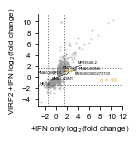

In [22]:
# read in DEseq2 outputs
V2_ID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-dox_CL048_noIFN-dox_varIFN.csv')
V2_nID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_noIFN-dox_CL048_noIFN-dox_varPlasmid.csv')
V2_InD = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-nodox_CL048_noIFN-dox_varIFN.csv')
filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A']

def combine_df(dflist, namelist):
    DF = pd.DataFrame()
    for df, name in zip(dflist, namelist):
        df = df[df['padj'] < 0.05]
        df = df[['symbol', 'log2FoldChange']].rename(columns={'symbol':'Gene', 'log2FoldChange':name})
        df = df[~df['Gene'].isin(filterout)]
        print('Sig diff expr genes for %s: %d' % (name, len(df[(df[name]>=1.5) | (df[name]<=-1.5)])))
        if len(DF) == 0:
            DF = df.copy()
        else:
            DF = pd.merge(DF, df, on='Gene', how='outer')
    return DF

x = 1.5
V2 = combine_df([V2_ID, V2_nID, V2_InD], ['IFN-dox', 'noIFN-dox', 'IFN-nodox'])
V2 = V2.set_index('Gene')
V2 = V2.dropna()
V2 = V2[['IFN-dox', 'noIFN-dox', 'IFN-nodox']]

# VIRF2+IFN vs IFN
plt.figure(figsize=(1.9, 1.9))
sns.scatterplot(data=V2[~((V2['IFN-nodox']>1.5) & (V2['IFN-dox']<1.5) & (V2['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V2[((V2['IFN-nodox']>1.5) & (V2['IFN-dox']<1.5) & (V2['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#DAA520', alpha=0.5, linewidth=0, s=4)
plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF2 +IFN log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V2[(V2['IFN-nodox']>1.5) & (V2['IFN-dox']<1.5) & (V2['IFN-dox']>-1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['IFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12])
plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10])
plt.annotate(xy=(11, -0.5), text='n = %d' % num, va='center', ha='right', fontsize=6, color='#DAA520')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF2-IFN_RNA-seq_scatter_IFN-genes_labeled.png', dpi=1200)


#### Make VIRF2 vs IFN scatterplot in Fig. S6M

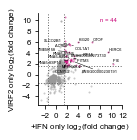

In [23]:
plt.figure(figsize=(1.9,1.9))
sns.scatterplot(data=V2[~((V2['IFN-nodox']>1.5) & (V2['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V2[((V2['IFN-nodox']>1.5) & (V2['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#c90076', alpha=0.5, linewidth=0, s=4)

plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF2 only log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V2[(V2['IFN-nodox']>1.5) & (V2['noIFN-dox']>1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2) & (plotDF['noIFN-dox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['noIFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12])
plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10])
plt.annotate(xy=(11, 10), text='n = %d' % num, ha='right', va='center', fontsize=6, color='#c90076')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF2-IFN_RNA-seq_scatter_IFN-genes_v2.png', dpi=1200)

#### Make VIRF3+IFN vs IFN scatterplot (not in manuscript)

Sig diff expr genes for IFN-dox: 1409
Sig diff expr genes for noIFN-dox: 970
Sig diff expr genes for IFN-nodox: 193


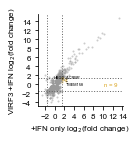

In [24]:
V3_ID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL194_IFN-dox_CL048_noIFN-dox_varIFN.csv')
V3_nID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL194_noIFN-dox_CL048_noIFN-dox_varPlasmid.csv')
V2_InD = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-nodox_CL048_noIFN-dox_varIFN.csv')
filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A']

def combine_df(dflist, namelist):
    DF = pd.DataFrame()
    for df, name in zip(dflist, namelist):
        df = df[df['padj'] < 0.05]
        df = df[['symbol', 'log2FoldChange']].rename(columns={'symbol':'Gene', 'log2FoldChange':name})
        df = df[~df['Gene'].isin(filterout)]
        print('Sig diff expr genes for %s: %d' % (name, len(df[(df[name]>=1.5) | (df[name]<=-1.5)])))
        if len(DF) == 0:
            DF = df.copy()
        else:
            DF = pd.merge(DF, df, on='Gene', how='outer')
    return DF

x = 1.5
V3 = combine_df([V3_ID, V3_nID, V2_InD], ['IFN-dox', 'noIFN-dox', 'IFN-nodox'])
V3 = V3.set_index('Gene')
V3 = V3.dropna()
V3 = V3[['IFN-dox', 'noIFN-dox', 'IFN-nodox']]

plt.figure(figsize=(1.9, 1.9))
sns.scatterplot(data=V3[~((V3['IFN-nodox']>1.5) & (V3['IFN-dox']<1.5) & (V3['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V3[((V3['IFN-nodox']>1.5) & (V3['IFN-dox']<1.5) & (V3['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#DAA520', alpha=0.5, linewidth=0, s=4)
plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF3 +IFN log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V3[(V3['IFN-nodox']>1.5) & (V3['IFN-dox']<1.5) & (V3['IFN-dox']>-1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['IFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12, 14])
plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
plt.annotate(xy=(13, 0), text='n = %d' % num, va='center', ha='right', fontsize=6, color='#DAA520')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF3-IFN_RNA-seq_scatter_IFN-genes_labeled.png', dpi=1200)


#### Make VIRF3 vs IFN scatterplot in Fig. S6N

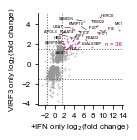

In [25]:
from adjustText import adjust_text

plt.figure(figsize=(1.9,1.9))
sns.scatterplot(data=V3[~((V3['IFN-nodox']>1.5) & (V3['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V3[((V3['IFN-nodox']>1.5) & (V3['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#c90076', alpha=0.5, linewidth=0, s=4)

plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF3 only log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V3[(V3['IFN-nodox']>1.5) & (V3['noIFN-dox']>1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2) & (plotDF['noIFN-dox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['noIFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12, 14])
plt.annotate(xy=(14, 2), text='n = %d' % num, ha='right', va='center', fontsize=6, color='#c90076')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF3-IFN_RNA-seq_scatter_IFN-genes_v2.png', dpi=1200)

#### Make VIRF4+IFN vs IFN scatterplot (not in manuscript)

Sig diff expr genes for IFN-dox: 564
Sig diff expr genes for noIFN-dox: 215
Sig diff expr genes for IFN-nodox: 193


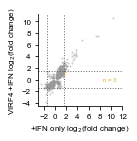

In [26]:
V4_ID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL195_IFN-dox_CL048_noIFN-dox_varIFN.csv')
V4_nID = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL195_noIFN-dox_CL048_noIFN-dox_varPlasmid.csv')
V2_InD = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL290_IFN-nodox_CL048_noIFN-dox_varIFN.csv')
filterout = ['EBNA2_B-B-B', 'EBNA2_A-A-A', 'EBNA2_B-A-B', 'EBNA2_A-B-A',
             'mCitrine', 'ORF10', 'VIRF3', 'VIRF4', 'VIRF2', 'IE1', 'RL5A']

def combine_df(dflist, namelist):
    DF = pd.DataFrame()
    for df, name in zip(dflist, namelist):
        df = df[df['padj'] < 0.05]
        df = df[['symbol', 'log2FoldChange']].rename(columns={'symbol':'Gene', 'log2FoldChange':name})
        df = df[~df['Gene'].isin(filterout)]
        print('Sig diff expr genes for %s: %d' % (name, len(df[(df[name]>=1.5) | (df[name]<=-1.5)])))
        if len(DF) == 0:
            DF = df.copy()
        else:
            DF = pd.merge(DF, df, on='Gene', how='outer')
    return DF

x = 1.5
V4 = combine_df([V4_ID, V4_nID, V2_InD], ['IFN-dox', 'noIFN-dox', 'IFN-nodox'])

V4 = V4.set_index('Gene')
V4 = V4.dropna()
V4 = V4[['IFN-dox', 'noIFN-dox', 'IFN-nodox']]

plt.figure(figsize=(1.9, 1.9))
sns.scatterplot(data=V4[~((V4['IFN-nodox']>1.5) & (V4['IFN-dox']<1.5) & (V4['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V4[((V4['IFN-nodox']>1.5) & (V4['IFN-dox']<1.5) & (V4['IFN-dox']>-1.5))], x='IFN-nodox', y='IFN-dox', color='#DAA520', alpha=0.5, linewidth=0, s=4)
plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF4 +IFN log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V4[(V4['IFN-nodox']>1.5) & (V4['IFN-dox']<1.5) & (V4['IFN-dox']>-1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['IFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12])
plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10])
plt.annotate(xy=(11, 0), text='n = %d' % num, va='center', ha='right', fontsize=6, color='#DAA520')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF4-IFN_RNA-seq_scatter_IFN-genes_labeled.png', dpi=1200)


#### Make VIRF4 vs IFN scatterplot in Fig. S6O

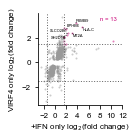

In [27]:
plt.figure(figsize=(1.9, 1.9))
sns.scatterplot(data=V4[~((V4['IFN-nodox']>1.5) & (V4['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#999999', alpha=0.5, linewidth=0, s=4)
sns.scatterplot(data=V4[((V4['IFN-nodox']>1.5) & (V4['noIFN-dox']>1.5))], x='IFN-nodox', y='noIFN-dox', color='#c90076', alpha=0.5, linewidth=0, s=4)

plt.xlabel('+IFN only log$_2$(fold change)')
plt.ylabel('VIRF4 only log$_2$(fold change)')
plt.axvline(x=1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=1.5, ls=':', color='#666666', lw=1)
plt.axvline(x=-1.5, ls=':', color='#666666', lw=1)
plt.axhline(y=-1.5, ls=':', color='#666666', lw=1)

plotDF = V4[(V4['IFN-nodox']>1.5) & (V4['noIFN-dox']>1.5)].reset_index()
num = len(plotDF)
plotDF = plotDF[(plotDF['IFN-nodox']>2) & (plotDF['noIFN-dox']>2)].reset_index()
labels = list(plotDF['Gene'])
xvals = list(plotDF['IFN-nodox'])
yvals = list(plotDF['noIFN-dox'])
sns.despine()
plt.xticks([-2, 0, 2, 4, 6, 8, 10, 12])
plt.annotate(xy=(11, 3.5), text='n = %d' % num, ha='right', va='center', fontsize=6, color='#c90076')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=4))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#000000', lw=0.5))

plt.savefig('../Individual Figure Panels/Figure S6/VIRF4-IFN_RNA-seq_scatter_IFN-genes_v2.png', dpi=1200)

### VIRF WT and mutant expression (FLAG staining)

In [3]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/VIRF_mutant_FLAG_stability_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
aggdf = df.groupby(by=['Construct', 'Protein', 'Condition',], as_index=False).mean()
normdf = aggdf.copy()
normdf

,Construct,Protein,Condition,Alexa 647-A,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,mCitrine-A,P1,P2,mCherry,FLAG
0,CL195,VIRF4 WT,dox,3.908605e+06,4.561779e+08,2.839723e+08,5.842320e+08,7.950466e+06,748771.586813,1.0,1.0,1.0,0.757143
1,CL290,VIRF2 WT,dox,3.057022e+06,4.570619e+08,2.812395e+08,6.408442e+08,1.128950e+07,850303.691096,1.0,1.0,1.0,0.674711
2,CL290,VIRF2 WT,nodox,8.912698e+05,4.647129e+08,2.842491e+08,6.745440e+08,8.573528e+06,706320.098160,1.0,1.0,1.0,0.003451
3,CL458,VIRF2 dL321-S325,dox,3.378267e+06,4.620235e+08,2.827630e+08,6.372723e+08,1.205186e+07,887360.997354,1.0,1.0,1.0,0.585416
4,CL458,VIRF2 dL321-S325,nodox,8.883506e+05,4.617073e+08,2.813597e+08,6.675870e+08,8.530178e+06,747653.875214,1.0,1.0,1.0,0.003890
5,CL459,VIRF4 W671A,dox,3.687049e+06,4.860500e+08,2.940739e+08,6.415006e+08,6.611760e+06,903548.493512,1.0,1.0,1.0,0.822863


#### Flow distributions (not featured in a figure panel)

C:\Users\cludw\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


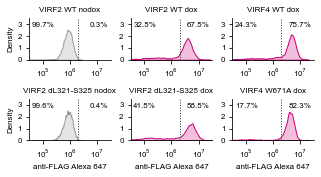

In [4]:
# quick overview of the data and how well the citrine gate is set
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

tempdf = df.copy()
tempdf['log10 Alexa 647'] = np.log10(tempdf['Alexa 647-A'])
tempdf['Sample'] = tempdf['Protein'] + ' ' + tempdf['Condition']
tempdf['Sample'] = pd.Categorical(tempdf['Sample'],
                                  categories=['VIRF2 WT nodox', 'VIRF2 WT dox', 'VIRF4 WT dox',
                                              'VIRF2 dL321-S325 nodox','VIRF2 dL321-S325 dox', 'VIRF4 W671A dox'],
                                  ordered=True)

tempdf = tempdf.sort_values(by='Sample')

labeldf = normdf.copy()
labeldf['Sample'] = labeldf['Protein'] + ' ' + labeldf['Condition']
labeldf['Sample'] = pd.Categorical(labeldf['Sample'],
                                   categories=['VIRF2 WT nodox', 'VIRF2 WT dox', 'VIRF4 WT dox',
                                               'VIRF2 dL321-S325 nodox','VIRF2 dL321-S325 dox', 'VIRF4 W671A dox'],
                                   ordered=True)
labeldf = labeldf.sort_values(by='Sample')
samples = list(labeldf['Sample'])

ON = list(labeldf['FLAG'])
ON = [round(on*100, 1) for on in ON]

OFF = [str(round(100-on, 1)) + '%' for on in ON]
ON = [str(on) + '%' for on in ON]

# pal = sns.color_palette(['#999999', '#AA6F73', '#AA6F73', '#999999', '#AA6F73', '#AA6F73'])
colors = ['#999999', '#c90076', '#c90076', '#999999', '#c90076', '#c90076']

fig, axes = plt.subplots(2, 3, figsize=(4.5, 2.5))
for ax, sample, color, on, off in zip(axes.flat, samples, colors, ON, OFF):
    sns.kdeplot(data=tempdf[tempdf['Sample']==sample], x='log10 Alexa 647', color=color, fill=True, bw_adjust=0.2, ax=ax)
    ax.axvline(x=np.log10(2e6), ls=':', color='#333333', lw=1)
    ax.set_xlim([4.5, 7.5])
    ax.set_xticks([5, 6, 7])
    ax.set_xticklabels(['10$^5$', '10$^6$', '10$^7$'], fontsize=8)
    if (ax == axes[1,0]) | (ax == axes[1,1]) | (ax == axes[1,2]):
        ax.set_xlabel('anti-FLAG Alexa 647', fontsize=8)
    else:
        ax.set_xlabel('')
    
    ax.set_ylim([0, 3.5])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels([0, 1, 2, 3], fontsize=8)
    if (ax == axes[0,0]) | (ax == axes[1,0]):
        ax.set_ylabel('Density', fontsize=8)
    else:
        ax.set_ylabel('')
    
    ax.set_title(sample, fontsize=8)
    ax.text(0.03, 0.9, off, transform=ax.transAxes, ha='left', va='top', fontsize=8)
    ax.text(0.97, 0.9, on, transform=ax.transAxes, ha='right', va='top', fontsize=8)   
    ax.grid(False)
    sns.despine()

plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S6/VIRFmut_FLAG_distribution.png', dpi=1200)


#### Barplot featured in Fig. S6P

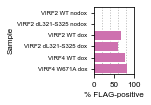

In [15]:
labeldf2 = labeldf.copy()
labeldf2['Sample'] = pd.Categorical(labeldf2['Sample'],
                                   categories=['VIRF2 WT nodox', 'VIRF2 dL321-S325 nodox', 'VIRF2 WT dox',  
                                               'VIRF2 dL321-S325 dox', 'VIRF4 WT dox', 'VIRF4 W671A dox'],
                                   ordered=True)
labeldf2 = labeldf2.sort_values(by='Sample')
# labeldf2['Protein'] = labeldf2['Protein'].str.split(' ').str.join('\n')
# labeldf2['Protein'] = labeldf2['Protein'].str.split('-').str.join('-\n')
labeldf2['FLAG'] = 100*labeldf2['FLAG']
lablist = list(labeldf2['Sample'])

plt.figure(figsize=(2.1, 1.5))
pal = sns.color_palette(['#999999', '#999999', '#dd62b4', '#dd62b4', '#dd62b4', '#dd62b4'])
sns.barplot(data=labeldf2, y='Sample', x='FLAG', palette=pal)
plt.yticks(ticks=plt.gca().get_yticks(), labels=lablist, fontsize=6)
plt.xlabel('% FLAG-positive')
plt.xlim(0, 100)
plt.xticks([0, 50, 100])
for i in range(0, 101, 20):
    plt.axvline(x=i, ls=':', color='#BBBBBB', lw=1, zorder=-1)

legend_elements = [Line2D([0], [0], marker='s', color='#FFFFFF', label='No Dox', mfc='#999999', markersize=7),
                   Line2D([0], [0], marker='s', color='#FFFFFF', label='Dox', mfc='#dd62b4', markersize=7)]

# plt.legend(handles=legend_elements, frameon=False, handlelength=0.75, handletextpad=0.5, labelspacing=0.2, borderpad=0.2,
#            loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('../Individual Figure Panels/Figure S6/VIRF2-VIRF4_WT-mut_FLAG_quantification_smaller.png', dpi=1200)

### END